Step 1: Dataset Preparation
We need to create a PyTorch dataset class that:

Navigates your dataset recursively (using your logic).
Loads images as grayscale.
Handles two input channels:
Channel 1: Non-Alcoholic (Grupo_0)
Channel 2: Alcoholic (Grupo_1 to Grupo_5)
Applies necessary transformations (Resizing, Normalization, etc.).

In [38]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

# Define transformations (convert to tensor, normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

class DualChannelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data_pairs = self._create_image_pairs()

    def _find_images(self, root_dir):
        """Find images and assign labels based on folder names."""
        image_paths = []
        for root, _, files in os.walk(root_dir):
            images = [f for f in files if f.endswith(".bmp")]
            for img in images:
                img_path = os.path.join(root, img)
                label = 0 if "Grupo_0" in root else 1  # Non-Alcoholic: 0, Alcoholic: 1
                image_paths.append((img_path, label))
        return image_paths

    def _create_image_pairs(self):
        """Create pairs of (non-alcoholic, alcoholic) images."""
        images = self._find_images(self.root_dir)
        non_alcoholic = [img for img in images if img[1] == 0]  # Grupo_0
        alcoholic = [img for img in images if img[1] == 1]  # Grupo_1 - Grupo_5

        min_length = min(len(non_alcoholic), len(alcoholic))  # Balance dataset
        pairs = list(zip(non_alcoholic[:min_length], alcoholic[:min_length]))
        return pairs

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        """Load two images (one non-alcoholic, one alcoholic)."""
        (img_path_1, _), (img_path_2, label) = self.data_pairs[idx]

        img_1 = cv2.imread(img_path_1, cv2.IMREAD_GRAYSCALE)  # Non-Alcoholic
        img_2 = cv2.imread(img_path_2, cv2.IMREAD_GRAYSCALE)  # Alcoholic

        if img_1 is None or img_2 is None:
            raise RuntimeError(f"Error loading images: {img_path_1} or {img_path_2}")

        img_1, img_2 = cv2.resize(img_1, (128, 128)), cv2.resize(img_2, (128, 128))

        if self.transform:
            img_1, img_2 = self.transform(img_1), self.transform(img_2)

        return (img_1, img_2), label  # Dual input

# Example usage:
dataset_root = r"C:\Users\Major Project\data"
dataset = DualChannelDataset(root_dir=dataset_root, transform=transform)
print(f"Dataset loaded with {len(dataset)} image pairs.")

# Load first sample
(sample, label) = dataset[0]
print(f"Sample shape: {sample[0].shape}, {sample[1].shape} | Label: {label}")


Dataset loaded with 2655 image pairs.
Sample shape: torch.Size([1, 128, 128]), torch.Size([1, 128, 128]) | Label: 1


Step 2: Implementing the Dual-Channel CNN Model
Now that we have our Dual-Channel Dataset, we need to create a PyTorch model that:

Processes two input channels separately.
Extracts features using convolutional layers.
Fuses both feature maps before classification.

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualChannelCNN(nn.Module):
    def __init__(self):
        super(DualChannelCNN, self).__init__()
        
        # First CNN branch (for Non-Alcoholic images - Grupo_0)
        self.branch1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second CNN branch (for Alcoholic images - Grupo_1 to Grupo_5)
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers after feature fusion
        self.fc = nn.Sequential(
            nn.Linear(64 * 32 * 32 * 2, 256),  # Combining both branches
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),  # Binary classification
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        # Pass images through separate CNN branches
        x1 = self.branch1(img1)
        x2 = self.branch2(img2)
        
        # Flatten feature maps
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        
        # Concatenate features from both branches
        x = torch.cat((x1, x2), dim=1)
        
        # Pass through fully connected layers
        out = self.fc(x)
        return out

# Initialize model
model = DualChannelCNN()
print(model)


DualChannelCNN(
  (branch1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (branch2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=131072, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


Step 3: Training Pipeline for Dual-Channel CNN
Now that we have our Dual-Channel CNN (DCCNN) model, let's set up the training process step by step:

Prepare DataLoader – Load images in batches.
Define Loss Function & Optimizer – Use Binary Cross-Entropy (since it's a binary classification).
Implement Training Loop – Forward pass, compute loss, backpropagate, and update weights.
Implement Validation Loop – Evaluate the model on unseen data.

Step 3.1: Create DataLoaders
We will split the dataset into training (80%) and validation (20%).

In [40]:
from torch.utils.data import DataLoader, random_split

# Define batch size
batch_size = 16  

# Split dataset into train and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}")


Training Samples: 2124, Validation Samples: 531


Step 3.2: Define Loss Function & Optimizer
We use:

Binary Cross-Entropy Loss (BCELoss)
Adam Optimizer for adaptive learning

In [41]:
import torch.optim as optim

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model.to(device)

criterion = nn.BCELoss()  # Binary classification loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate 0.001


Step 3.3: Implement Training Loop
The model will:

Forward pass: Predict outputs for images.
Compute loss: Compare predictions with actual labels.
Backward pass: Update weights using backpropagation.

In [42]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0

        for (img1, img2), labels in train_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device, dtype=torch.float32)

            optimizer.zero_grad()  # Clear previous gradients

            outputs = model(img1, img2).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Train model for 10 epochs
train_model(model, train_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], Loss: 0.0050
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


Step 3.4: Implement Validation Loop
We evaluate the model using the validation dataset after training

In [43]:
def evaluate_model(model, val_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for (img1, img2), labels in val_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device, dtype=torch.float32)

            outputs = model(img1, img2).squeeze()
            predicted = (outputs > 0.5).float()  # Convert probabilities to 0/1 labels

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

# Evaluate the trained model
evaluate_model(model, val_loader)


Validation Accuracy: 100.00%


Step 3.5: Save the Model
Once training is complete, we should save the model’s state so we can load it later for testing or deployment.

In [44]:
# Define model save path
model_save_path = "dual_channel_cnn.pth"

# Save model state
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to dual_channel_cnn.pth


Step 4: Model Testing on New Images
Now that our Dual-Channel CNN (DCCNN) is trained, we need to test it on new images.

📌 Step 4.1: Load the Trained Model
Before testing, let's load the trained model.

In [47]:
# Load required libraries
import torch
import cv2
import numpy as np
from torchvision import transforms

# Load the trained model
model = DualChannelCNN()  # Initialize the model architecture
model.load_state_dict(torch.load("dual_channel_cnn.pth"))
model.eval()  # Set model to evaluation mode
print("Model loaded successfully!")


Model loaded successfully!


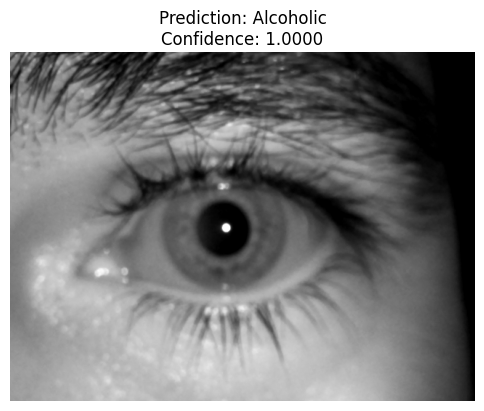

In [48]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model (Ensure the path is correct)
model_path = r"C:\Users\Major Project\dual_channel_cnn.pth"  # Change if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the existing model
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set to evaluation mode

# Image preprocessing function
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    image = cv2.resize(image, (128, 128))  # Resize to model input size
    image = image.astype(np.float32) / 255.0  # Normalize to [0,1]
    image = torch.tensor(image).unsqueeze(0).unsqueeze(0)  # Add batch & channel dim
    return image.to(device)

# Path of the image to be predicted
image_path = r"C:\Users\Major Project\data\Grupo_2\E_2_0\Iritech\E_2_0_0\E_2_0_0_L_5\E_2_0_0_L_M_N_N_1979_0_2017.bmp"

# Preprocess the input image
img1 = preprocess_image(image_path)

# Create a dummy second image (all zeros)
img2 = torch.zeros_like(img1).to(device)

# Perform inference
with torch.no_grad():
    output = model(img1, img2).item()

# Interpret prediction
label = "Alcoholic" if output > 0.5 else "Non-Alcoholic"
confidence = output if output > 0.5 else 1 - output  # Confidence score

# Display the image with prediction results
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6, 6))
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title(f"Prediction: {label}\nConfidence: {confidence:.4f}")
plt.show()


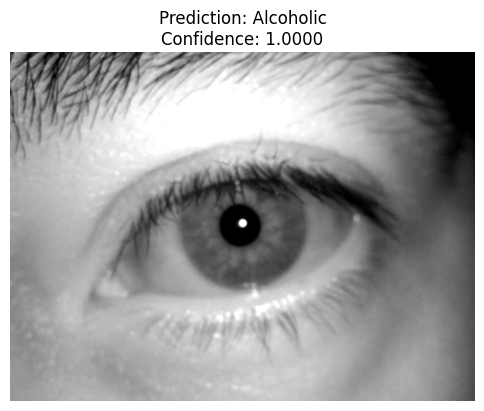

In [21]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model (Ensure the path is correct)
model_path = r"C:\Users\Major Project\dual_channel_cnn.pth"  # Change if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the existing model
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set to evaluation mode

# Image preprocessing function
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    image = cv2.resize(image, (128, 128))  # Resize to model input size
    image = image.astype(np.float32) / 255.0  # Normalize to [0,1]
    image = torch.tensor(image).unsqueeze(0).unsqueeze(0)  # Add batch & channel dim
    return image.to(device)

# Path of the image to be predicted
image_path = r"C:\Users\Major Project\data\Grupo_0\E_0_0\IriTech\E_0_0_0\E_0_0_0_L_5\E_0_0_0_L_M_N_N_1981_0_2017.bmp"

# Preprocess the input image
img1 = preprocess_image(image_path)

# Create a dummy second image (all zeros)
img2 = torch.zeros_like(img1).to(device)

# Perform inference
with torch.no_grad():
    output = model(img1, img2).item()

# Interpret prediction
label = "Alcoholic" if output == 1  else "Non-Alcoholic"
confidence = output if output > 0.5 else 1 - output  # Confidence score

# Display the image with prediction results
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6, 6))
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title(f"Prediction: {label}\nConfidence: {confidence:.4f}")
plt.show()
